# Compare the effect of different scalers on data with outliers

Feature 0 (median income in a block) and feature 5 (average house occupancy) of the California Housing dataset have very different scales and contain some very large outliers. These two characteristics lead to difficulties to visualize the data and, more importantly, they can degrade the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators.

Indeed many estimators are designed with the assumption that each feature takes values close to zero or more importantly that all features vary on comparable scales. In particular, metric-based and gradient-based estimators often assume approximately standardized data (centered features with unit variances). A notable exception are decision tree-based estimators that are robust to arbitrary scaling of the data.

This example uses different scalers, transformers, and normalizers to bring the data within a pre-defined range.

Scalers are linear (or more precisely affine) transformers and differ from each other in the way they estimate the parameters used to shift and scale each feature.

QuantileTransformer provides non-linear transformations in which distances between marginal outliers and inliers are shrunk. PowerTransformer provides non-linear transformations in which data is mapped to a normal distribution to stabilize variance and minimize skewness.

Unlike the previous transformations, normalization refers to a per sample transformation instead of a per feature transformation.

In [1]:
import matplotlib as mpl
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

In [10]:
dataset = fetch_california_housing()

X_full, y_full = dataset.data, dataset.target

feature_names = dataset.feature_names

feature_mapping = {
    "MedInc": "Median income in block",
    "HouseAge": "Median house age in block",
    "AveRooms": "Average number of rooms",
    "AveBedrms": "Average number of bedrooms",
    "Population": "Block population",
    "AveOccup": "Average house occupancy",
    "Latitude": "House block latitude",
    "Longitude": "House block longitude",
}

# Take only 2 features to make visualization easier
# Feature MedInc has a long tail distribution.
# Feature AveOccup has a few but very large outliers.
features = ["MedInc", "AveOccup"]
features_idx = [feature_names.index(feature) for feature in features]
X = X_full[:, features_idx]

distributions = [
    ("Unscaled data", X),
    ("Data after standard scaling", StandardScaler().fit_transform(X)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X)),
    (
        "Data after robust scaling",
        RobustScaler(quantile_range=(25, 75)).fit_transform(X),
    ),
    (
        "Data after power transformation (Yeo-Johnson)",
        PowerTransformer(method="yeo-johnson").fit_transform(X),
    ),
    (
        "Data after power transformation (Box-Cox)",
        PowerTransformer(method="box-cox").fit_transform(X),
    ),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)


In [11]:
# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, "plasma_r", cm.hot_r)


def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return (
        (ax_scatter, ax_histy, ax_histx),
        (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
        ax_colorbar,
    )


def plot_distribution(axes, X, y, hist_nbins=50, title="", x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker="o", s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(
        X[:, 1], bins=hist_nbins, orientation="horizontal", color="grey", ec="grey"
    )
    hist_X1.axis("off")

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(
        X[:, 0], bins=hist_nbins, orientation="vertical", color="grey", ec="grey"
    )
    hist_X0.axis("off")

In [12]:
def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(
        axarr[0],
        X,
        y,
        hist_nbins=200,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Full data",
    )

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) & np.all(
        X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1
    )
    plot_distribution(
        axarr[1],
        X[non_outliers_mask],
        y[non_outliers_mask],
        hist_nbins=50,
        x0_label=feature_mapping[features[0]],
        x1_label=feature_mapping[features[1]],
        title="Zoom-in",
    )

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(
        ax_colorbar,
        cmap=cmap,
        norm=norm,
        orientation="vertical",
        label="Color mapping for values of y",
    )

## Original data

Each transformation is plotted showing two transformed features, with the left plot showing the entire dataset, and the right zoomed-in to show the dataset without the marginal outliers. A large majority of the samples are compacted to a specific range, [0, 10] for the median income and [0, 6] for the average house occupancy. Note that there are some marginal outliers (some blocks have average occupancy of more than 1200). Therefore, a specific pre-processing can be very beneficial depending of the application. In the following, we present some insights and behaviors of those pre-processing methods in the presence of marginal outliers.



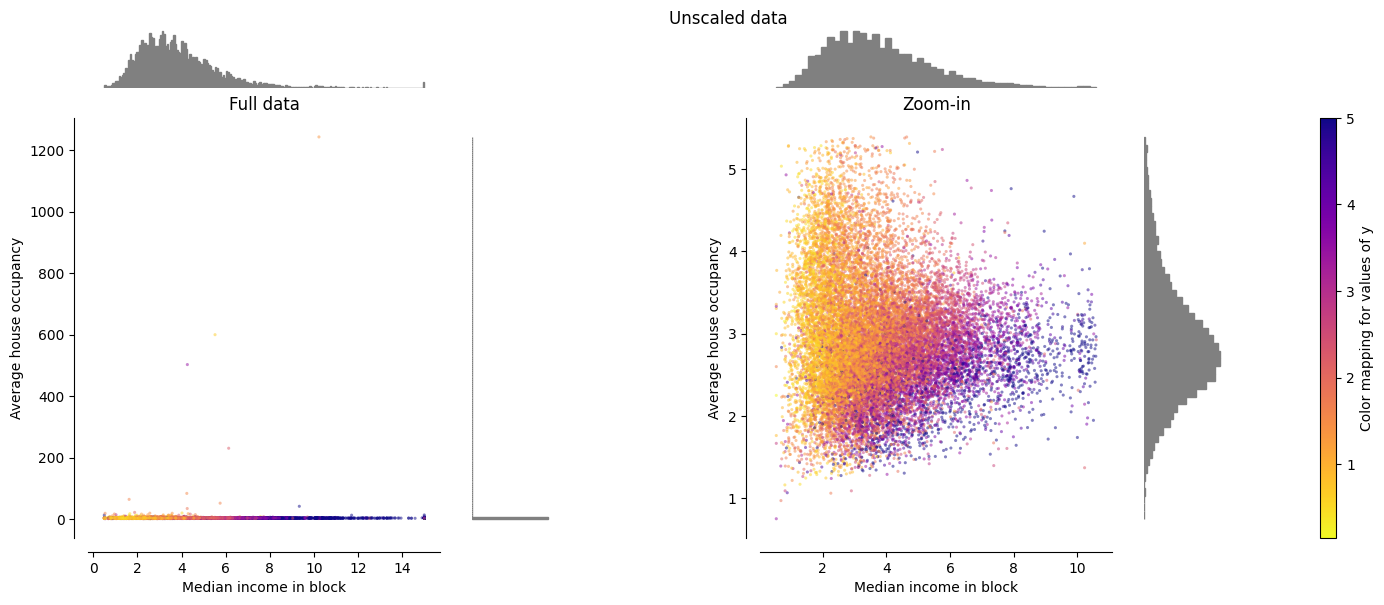

In [13]:
make_plot(0)

## StandardScaler

StandardScaler removes the mean and scales the data to unit variance. The scaling shrinks the range of the feature values as shown in the left figure below. However, the outliers have an influence when computing the empirical mean and standard deviation. Note in particular that because the outliers on each feature have different magnitudes, the spread of the transformed data on each feature is very different: most of the data lie in the [-2, 4] range for the transformed median income feature while the same data is squeezed in the smaller [-0.2, 0.2] range for the transformed average house occupancy.

StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.

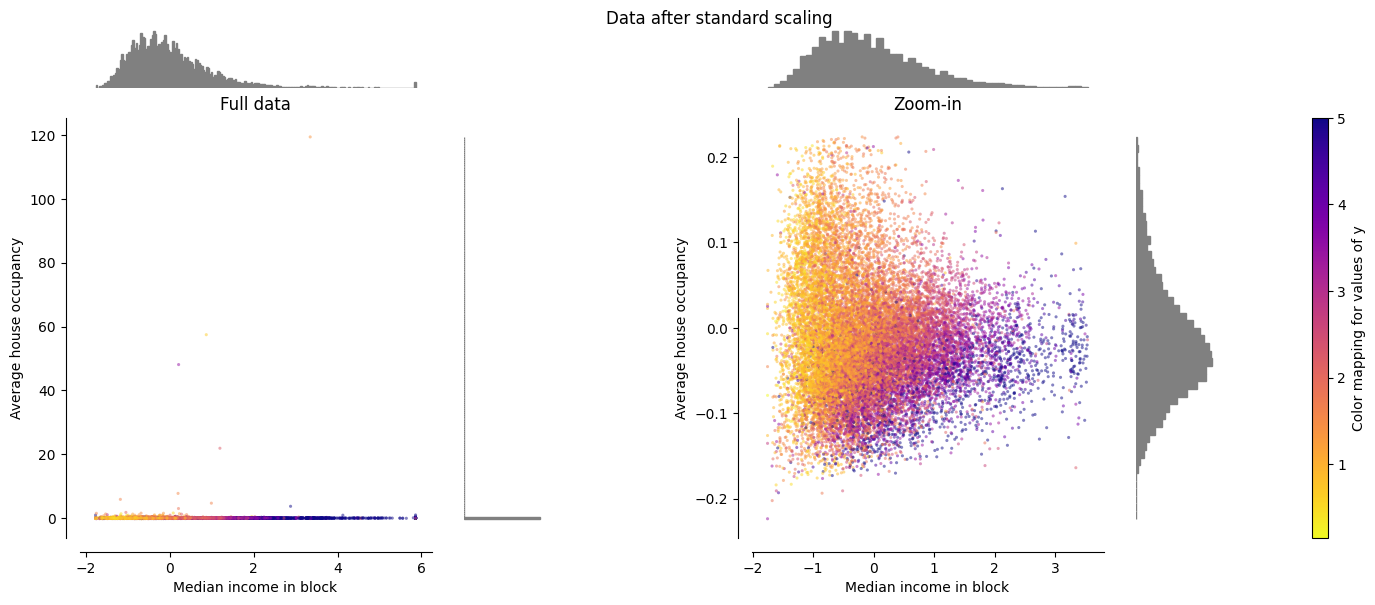

In [5]:
make_plot(1)

## MinMax scaler

MaxAbsScaler is similar to MinMaxScaler except that the values are mapped across several ranges depending on whether negative OR positive values are present. If only positive values are present, the range is [0, 1]. If only negative values are present, the range is [-1, 0]. If both negative and positive values are present, the range is [-1, 1]. On positive only data, both MinMaxScaler and MaxAbsScaler behave similarly. MaxAbsScaler therefore also suffers from the presence of large outliers.



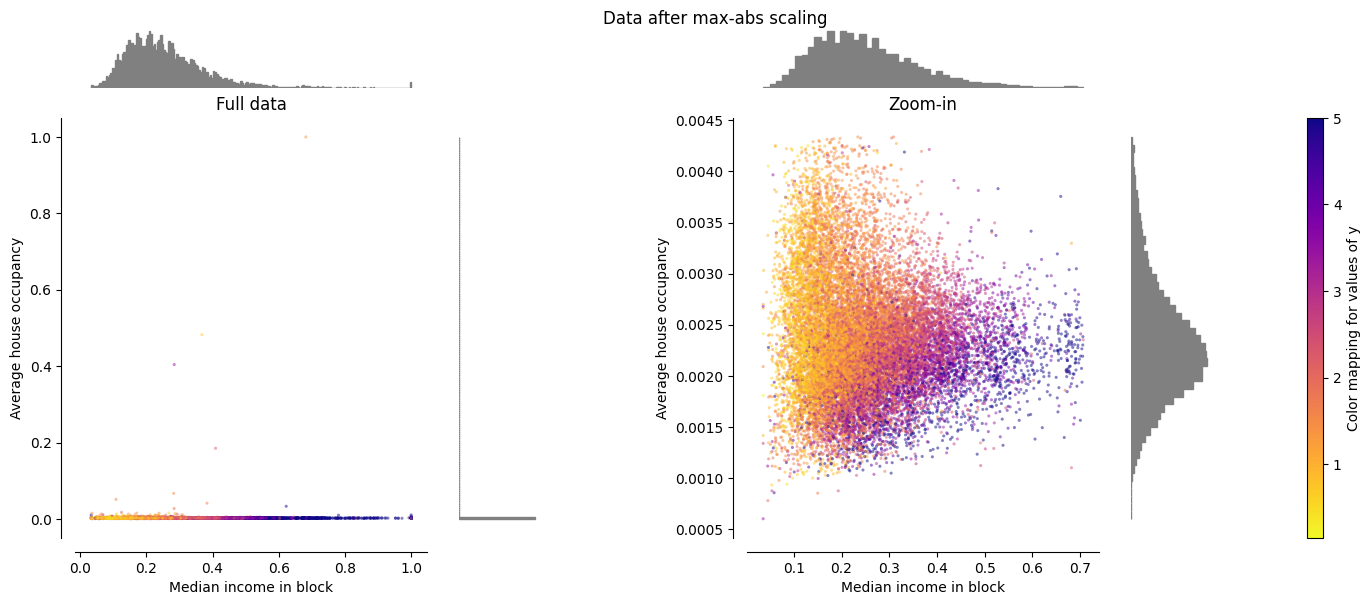

In [6]:
make_plot(3)

## RobustScaler

Unlike the previous scalers, the centering and scaling statistics of RobustScaler are based on percentiles and are therefore not influenced by a small number of very large marginal outliers. Consequently, the resulting range of the transformed feature values is larger than for the previous scalers and, more importantly, are approximately similar: for both features most of the transformed values lie in a [-2, 3] range as seen in the zoomed-in figure. Note that the outliers themselves are still present in the transformed data. If a separate outlier clipping is desirable, a non-linear transformation is required (see below).



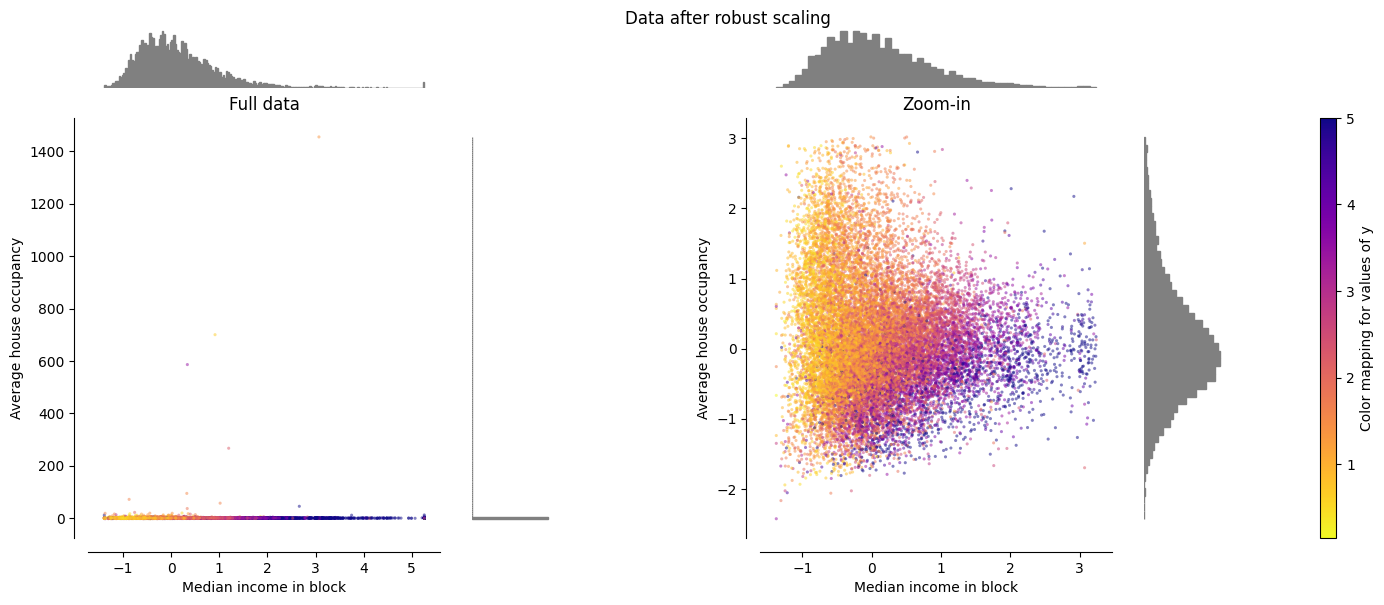

In [7]:
make_plot(4)

## PowerTransformer

PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness. Currently the Yeo-Johnson and Box-Cox transforms are supported and the optimal scaling factor is determined via maximum likelihood estimation in both methods. By default, PowerTransformer applies zero-mean, unit variance normalization. Note that Box-Cox can only be applied to strictly positive data. Income and average house occupancy happen to be strictly positive, but if negative values are present the Yeo-Johnson transformed is preferred.



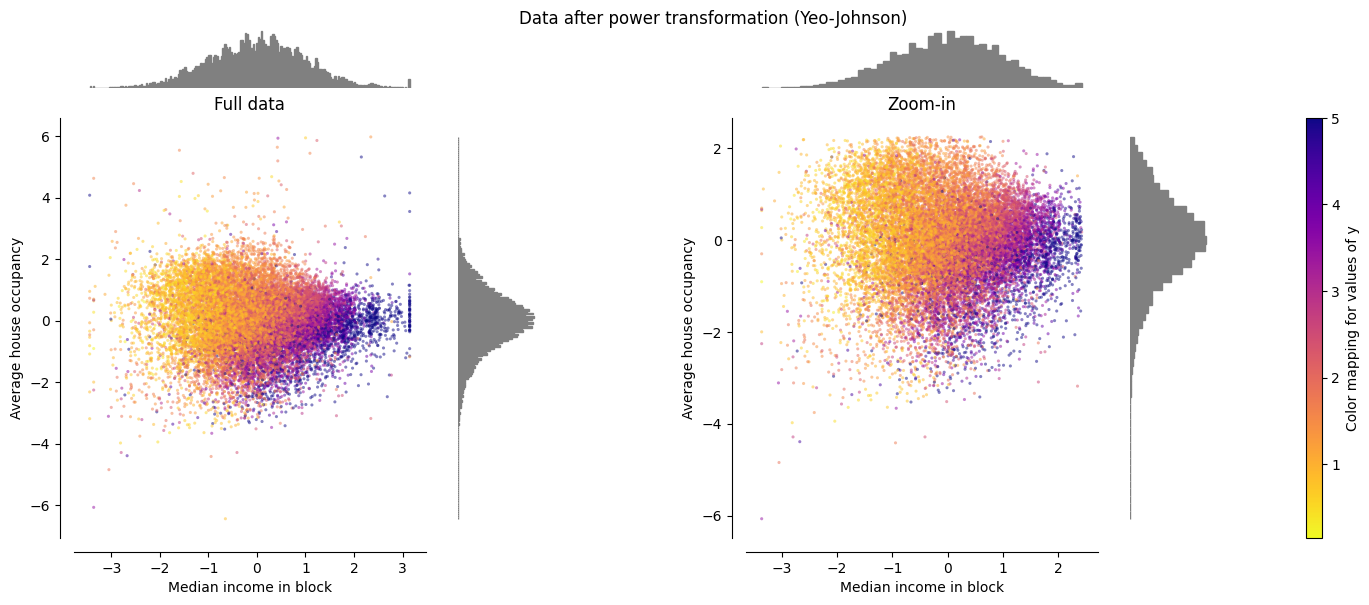

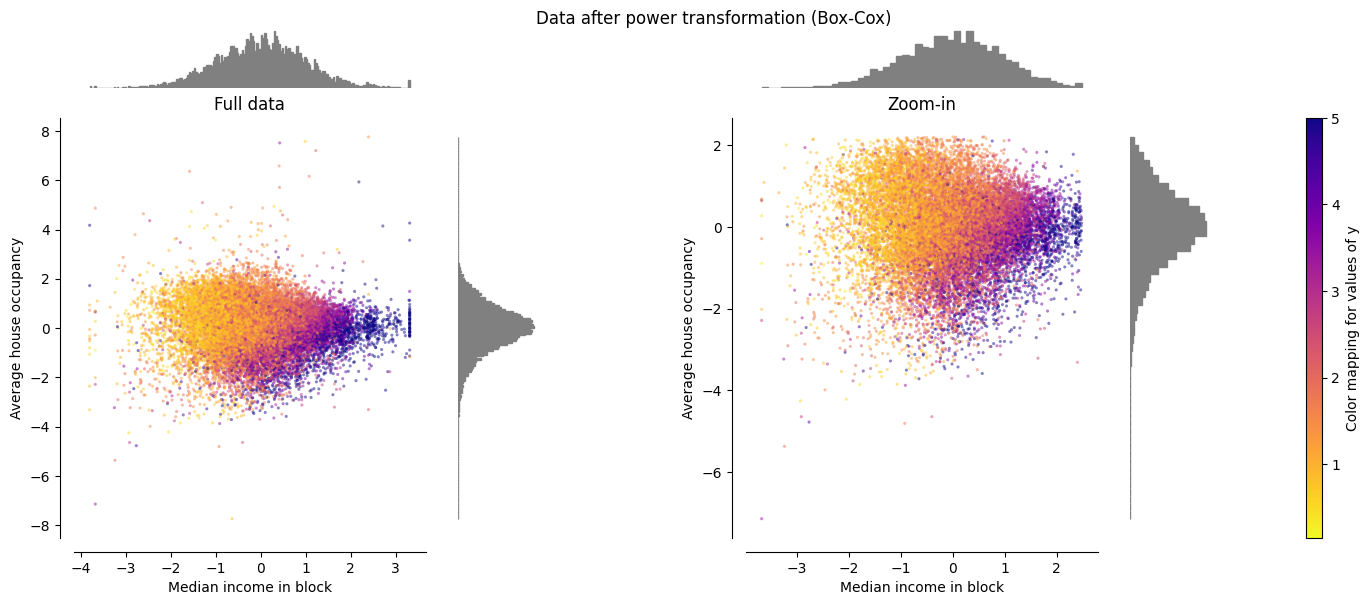

In [8]:
make_plot(5)
make_plot(6)

## Normalizer

The Normalizer rescales the vector for each sample to have unit norm, independently of the distribution of the samples. It can be seen on both figures below where all samples are mapped onto the unit circle. In our example the two selected features have only positive values; therefore the transformed data only lie in the positive quadrant. This would not be the case if some original features had a mix of positive and negative values.



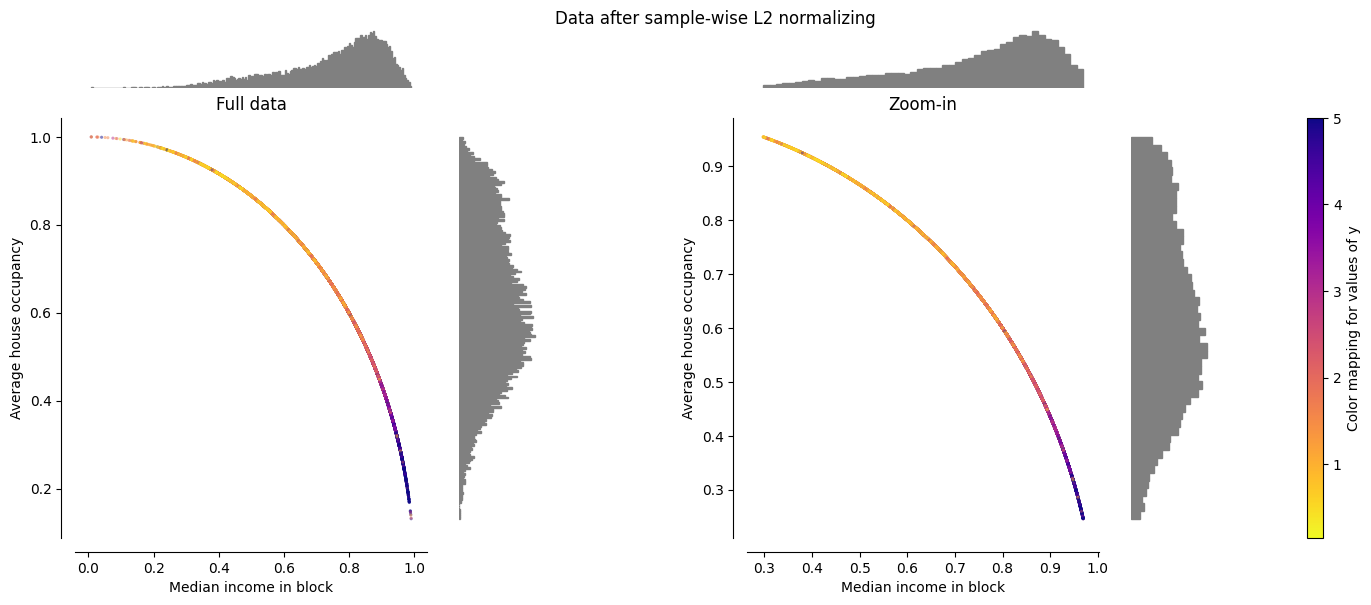

In [9]:
make_plot(9)

plt.show()

# Scaling Techniques in scikit-learn

Scaling is an important preprocessing step in many machine learning workflows. It helps to standardize the range of features in your dataset, which can be crucial for many machine learning algorithms. Let's explore four common scaling techniques from scikit-learn: StandardScaler, MinMaxScaler, RobustScaler, and Normalizer.

## 1. StandardScaler

StandardScaler standardizes features by removing the mean and scaling to unit variance. This scaler is widely used and assumes your data is normally distributed.

### How it works:
1. It calculates the mean and standard deviation for each feature.
2. For each data point, it subtracts the mean and divides by the standard deviation.

### Formula:
z = (x - μ) / σ

Where:
- z is the scaled value
- x is the original value
- μ is the mean of the feature
- σ is the standard deviation of the feature

### Code example:

```python
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sample data
data = np.array([[1, 2], [3, 4], [5, 6]])

# Initialize and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

print("Original data:\n", data)
print("\nScaled data:\n", scaled_data)
```

## 2. MinMaxScaler

MinMaxScaler scales features to a fixed range, typically between 0 and 1. This is useful when you want to preserve zero entries in sparse data or when the distribution of your data is not Gaussian or unknown.

### How it works:
1. It finds the minimum and maximum values for each feature.
2. It scales each feature to the given range (default is [0, 1]).

### Formula:
z = (x - min(x)) / (max(x) - min(x))

Where:
- z is the scaled value
- x is the original value
- min(x) is the minimum value of the feature
- max(x) is the maximum value of the feature

### Code example:

```python
from sklearn.preprocessing import MinMaxScaler

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Original data:\n", data)
print("\nScaled data:\n", scaled_data)
```

## 3. RobustScaler

RobustScaler scales features using statistics that are robust to outliers. This scaler is useful if your data contains many outliers.

### How it works:
1. It calculates the median and interquartile range for each feature.
2. It scales features by subtracting the median and dividing by the interquartile range.

### Formula:
z = (x - median(x)) / IQR(x)

Where:
- z is the scaled value
- x is the original value
- median(x) is the median of the feature
- IQR(x) is the interquartile range of the feature

### Code example:

```python
from sklearn.preprocessing import RobustScaler

# Initialize and fit the scaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

print("Original data:\n", data)
print("\nScaled data:\n", scaled_data)
```

## 4. Normalizer

Normalizer scales each sample (row) independently of other samples to have unit norm. This is often used in text classification or clustering.

### How it works:
1. It calculates the norm (magnitude) of each sample.
2. It divides each feature in the sample by the calculated norm.

### Formula:
z = x / ||x||

Where:
- z is the normalized vector
- x is the original vector
- ||x|| is the norm of the vector

### Code example:

```python
from sklearn.preprocessing import Normalizer

# Initialize and fit the normalizer
normalizer = Normalizer()
normalized_data = normalizer.fit_transform(data)

print("Original data:\n", data)
print("\nNormalized data:\n", normalized_data)
```

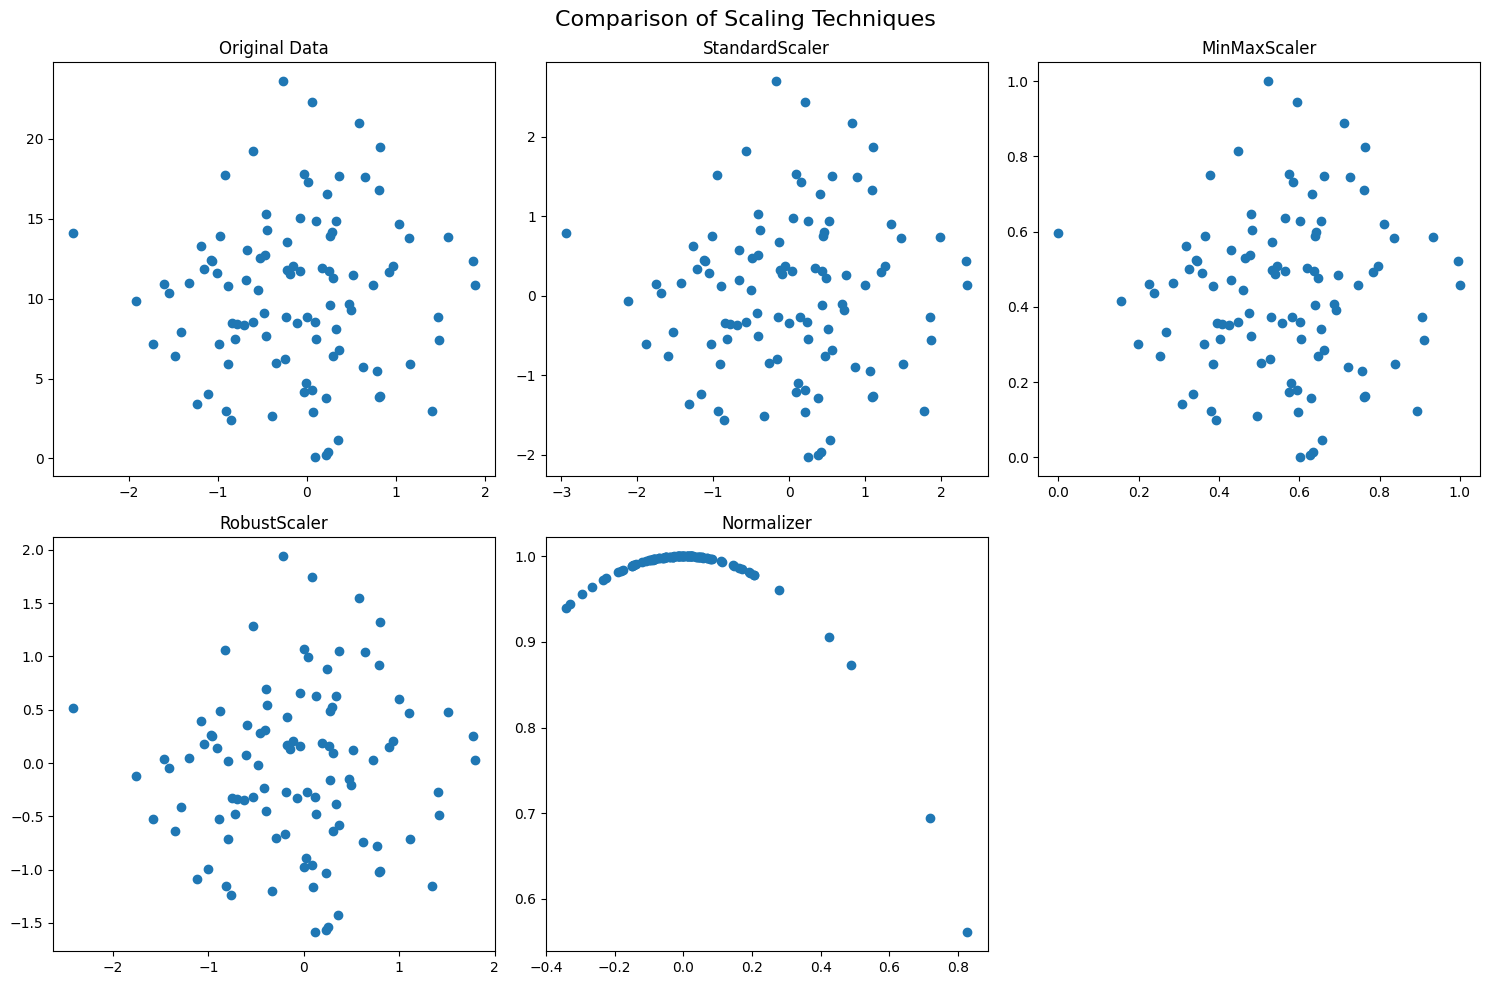

In [14]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import numpy as np

# Generate sample data
np.random.seed(42)
data = np.random.randn(100, 2)
data[:, 1] = 5 * data[:, 1] + 10  # Scale the second feature

# Initialize scalers
scalers = [
    ("StandardScaler", StandardScaler()),
    ("MinMaxScaler", MinMaxScaler()),
    ("RobustScaler", RobustScaler()),
    ("Normalizer", Normalizer())
]

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Comparison of Scaling Techniques", fontsize=16)

# Plot original data
axs[0, 0].scatter(data[:, 0], data[:, 1])
axs[0, 0].set_title("Original Data")

# Plot scaled data
for idx, (name, scaler) in enumerate(scalers):
    scaled_data = scaler.fit_transform(data)
    row, col = divmod(idx + 1, 3)
    axs[row, col].scatter(scaled_data[:, 0], scaled_data[:, 1])
    axs[row, col].set_title(name)

# Remove empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

[Previous content remains the same]

## When to Use Each Scaling Technique

Choosing the right scaling technique depends on your data characteristics and the requirements of your machine learning algorithm. Here's a detailed guide on when to use each scaler:

### 1. StandardScaler

Use StandardScaler when:

- Your data follows a normal distribution (Gaussian distribution) for each feature.
- You're using algorithms that assume normally distributed data, such as:
  - Linear Regression
  - Logistic Regression
  - Neural Networks
  - Support Vector Machines (SVM)
  - Principal Component Analysis (PCA)
- You want to preserve zero as a meaningful value (unlike MinMaxScaler).
- Outliers are not a significant concern in your dataset.

Advantages:
- Maintains useful information about outliers.
- Preserves zero values.
- Works well with algorithms that assume normality.

Disadvantages:
- Sensitive to outliers, which can affect the mean and standard deviation.

### 2. MinMaxScaler

Use MinMaxScaler when:

- You want to scale your data to a fixed range, typically [0, 1].
- Your data doesn't follow a normal distribution.
- You're using algorithms that don't make assumptions about data distribution, such as:
  - K-Nearest Neighbors (KNN)
  - Neural Networks (in some cases)
  - Algorithms using distance metrics (e.g., cosine similarity)
- You want to preserve the zero values in sparse data.
- You're working with image processing tasks where pixel intensities need to be scaled to [0, 1].

Advantages:
- Preserves the shape of the original distribution.
- Doesn't center the data, which can be useful for sparse datasets.
- Reduces the effects of outliers compared to StandardScaler.

Disadvantages:
- Doesn't handle outliers well; they can compress the "normal" data into a small interval.

### 3. RobustScaler

Use RobustScaler when:

- Your data contains many outliers.
- You want to minimize the impact of outliers on your scaling.
- You're working with financial data or other domains where extreme values are common but shouldn't overly influence the scaling.
- You're using algorithms that are sensitive to outliers.

Advantages:
- Robust to outliers due to the use of median and interquartile range.
- Preserves useful information for further statistical analysis.
- Works well with algorithms sensitive to outliers.

Disadvantages:
- May not scale the data as precisely as StandardScaler for normally distributed data without outliers.

### 4. Normalizer

Use Normalizer when:

- You want to scale each sample (row) to have unit norm.
- You're working with text data for text classification or clustering.
- You're using algorithms that rely on the angle between samples rather than their magnitude, such as:
  - Cosine similarity
  - Some neural network architectures
- You're dealing with data where the scale of each sample is not important, but the proportion between features is.

Advantages:
- Useful for text classification and clustering.
- Helps when you care about the proportion of features rather than their absolute values.

Disadvantages:
- Loses absolute scale information, which might be important in some cases.
- May not be suitable when the magnitude of each sample is meaningful.

### General Guidelines

1. **Data Exploration**: Always start by exploring your data. Understanding its distribution, the presence of outliers, and the nature of your features will guide your choice of scaler.

2. **Algorithm Requirements**: Consider the assumptions and requirements of your chosen machine learning algorithm. Some algorithms perform better with certain types of scaled data.

3. **Domain Knowledge**: Use your domain expertise. In some fields, certain scaling methods are preferred due to interpretability or established practices.

4. **Experiment**: Don't hesitate to try different scalers and compare their performance. Cross-validation can help you choose the best scaler for your specific problem.

5. **Consistency**: Apply the same scaling method to both your training and test data to ensure consistency.

6. **Feature Importance**: If the relative importance of features is crucial, be cautious with techniques that might alter this relationship.

Remember, there's no one-size-fits-all solution. The best scaling technique often depends on your specific dataset and the problem you're trying to solve. It's always a good practice to experiment with different techniques and evaluate their impact on your model's performance.

Some key points to remember:

StandardScaler is great for normally distributed data and algorithms that assume normality.
MinMaxScaler is useful when you need a specific range and for preserving zero values in sparse data.
RobustScaler shines when dealing with datasets containing many outliers.
Normalizer is particularly useful in text processing and when you care about the proportion between features rather than their absolute values.

The choice of scaler can significantly impact your model's performance, so it's often worth experimenting with different techniques.

# Importance of feature scaling

Feature scaling through standardization, also called Z-score normalization, is an important preprocessing step for many machine learning algorithms. It involves rescaling each feature such that it has a standard deviation of 1 and a mean of 0.

Even if tree based models are (almost) not affected by scaling, many other algorithms require features to be normalized, often for different reasons: to ease the convergence (such as a non-penalized logistic regression), to create a completely different model fit compared to the fit with unscaled data (such as KNeighbors models). The latter is demoed on the first part of the present example.

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform="pandas")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaled_X_train = scaler.fit_transform(X_train)

For the sake of visualizing the decision boundary of a KNeighborsClassifier, in this section we select a subset of 2 features that have values with different orders of magnitude.

Keep in mind that using a subset of the features to train the model may likely leave out feature with high predictive impact, resulting in a decision boundary that is much worse in comparison to a model trained on the full set of features

In [3]:
def fit_and_plot_model(X_plot, y, clf, ax):
    clf.fit(X_plot, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    disp.ax_.scatter(X_plot["proline"], X_plot["hue"], c=y, s=20, edgecolor="k")
    disp.ax_.set_xlim((X_plot["proline"].min(), X_plot["proline"].max()))
    disp.ax_.set_ylim((X_plot["hue"].min(), X_plot["hue"].max()))
    return disp.ax_

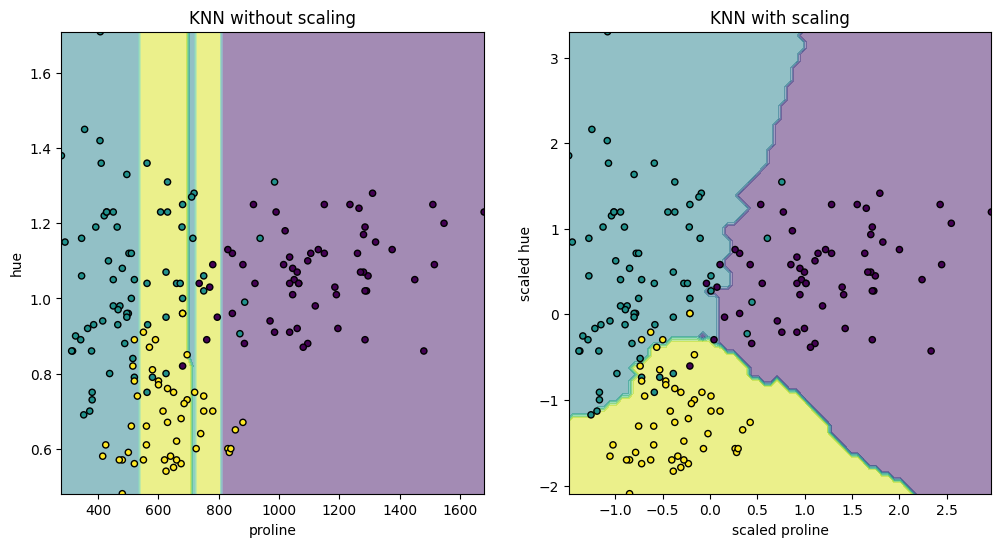

In [4]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

X_plot = X[["proline", "hue"]]
X_plot_scaled = scaler.fit_transform(X_plot)
clf = KNeighborsClassifier(n_neighbors=20)




fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fit_and_plot_model(X_plot, y, clf, ax1)
ax1.set_title("KNN without scaling")

fit_and_plot_model(X_plot_scaled, y, clf, ax2)
ax2.set_xlabel("scaled proline")
ax2.set_ylabel("scaled hue")
_ = ax2.set_title("KNN with scaling")

Here the decision boundary shows that fitting scaled or non-scaled data lead to completely different models. The reason is that the variable “proline” has values which vary between 0 and 1,000; whereas the variable “hue” varies between 1 and 10. Because of this, distances between samples are mostly impacted by differences in values of “proline”, while values of the “hue” will be comparatively ignored. If one uses StandardScaler to normalize this database, both scaled values lay approximately between -3 and 3 and the neighbors structure will be impacted more or less equivalently by both variables.